### We first need to define probabilistic orthonormal hermite polynomials for standard Gaussian as well as define the corresponding scalar product and triple product

In [2]:
import numpy as np
from scipy.special import hermite
from scipy.integrate import quad ## FUNCTIONS TO IMPLEMENT GAUSS-QUADRATURE
from scipy.integrate import quad_vec ## FUNCTIONS TO IMPLEMENT GAUSS-QUADRATURE
import matplotlib.pyplot as plt
from scipy.linalg import eigh
np.random.seed(20)

In [3]:
# Define the orthonormal probabilistic Hermite polynomial
def orthonormal_prob_hermite(n):
    return lambda x: hermite(n)(x/np.sqrt(2)) / np.sqrt(2**n * np.math.factorial(n))

# Define the integrand for scalar product
def scalar_int(i,j):
    return lambda x:orthonormal_prob_hermite(i)(x) * orthonormal_prob_hermite(j)(x) * np.exp(-(x**2/2))/np.sqrt(2*np.pi)

# Define the integrand for triple product
def triple_int(i,j,k):
    return lambda x:orthonormal_prob_hermite(i)(x) * orthonormal_prob_hermite(j)(x)* orthonormal_prob_hermite(k)(x) * np.exp(-(x**2/2))/np.sqrt(2*np.pi)

# Integrate to verify orthonormality
integral1, _ = quad(scalar_int(2,2), -np.inf, np.inf)
integral2, _ = quad(scalar_int(2,3), -np.inf, np.inf)
print(f"The scalar product of the orthonormal probabilistic Hermite polynomials H_2(x) and H_2(x) is approximately {integral1}")
print(f"The scalar product of the orthonormal probabilistic Hermite polynomials H_2(x) and H_3(x) is approximately {integral2}")


The scalar product of the orthonormal probabilistic Hermite polynomials H_2(x) and H_2(x) is approximately 1.0000000000000022
The scalar product of the orthonormal probabilistic Hermite polynomials H_2(x) and H_3(x) is approximately 0.0


In [4]:
test, _ = quad(lambda x:orthonormal_prob_hermite(3)(x) * orthonormal_prob_hermite(4)(x)* orthonormal_prob_hermite(5)(x) * np.exp(-(x**2/2))/np.sqrt(2*np.pi), -np.inf, np.inf)
test

10.95445115010332

##### DEFINING THE KERNEL FUNCTIONS

In [5]:
## defining kernel derivative function

def W2(x, l):
    R = np.abs(x) / l
    a = 1 / l
    mask1 = R <= 1
    mask2 = np.logical_and(R > 1, R < 2)
    result = np.zeros_like(R)
    result[mask1] = (2/3 - R[mask1]**2 + 0.5 * R[mask1]**3) * a
    result[mask2] = ((2 - R[mask2])**3) / 6 * a
    return result

def kernel(x,h):
    rr=np.abs(x)
    q=rr/h
    drx=x/(h*rr)
    alpha_=2/(3*h)
    mask1 = q < 1
    mask2 = np.logical_and(q >= 1, q < 2)
    # print(mask1.shape)
    result = np.zeros_like(q)
    result[mask1]=alpha_*(-3*q[mask1]+2.25*q[mask1]**2)*drx[mask1]
    result[mask2]=-alpha_*0.75*(2-q[mask2])**2*drx[mask2]
    return result

def squared_exponential_kernel(x1,x2,sigma=1,l=0.1):
    K = sigma * np.exp(-0.5 * (x1[:, None] - x2[None, :])**2 / l)
    return K


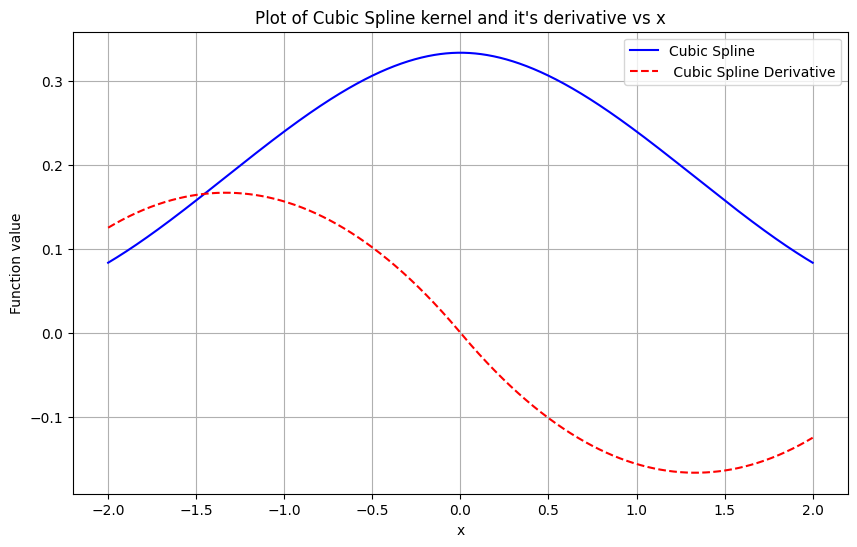

In [6]:
# Define the range of x values
x_values = np.linspace(-2, 2, 1200)

# Define a specific value for l
l = 2

# Calculate W2 and W2_d for each x value
W2_values = W2(x_values, l)
W2_d_values = kernel(x_values, l)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_values, W2_values, label='Cubic Spline', color='b')
plt.plot(x_values, W2_d_values, label=' Cubic Spline Derivative', color='r', linestyle='--')
plt.xlabel('x')
plt.ylabel('Function value')
plt.title('Plot of Cubic Spline kernel and it\'s derivative vs x')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
integral1, _ = quad(lambda x: W2(x-0,0.1), -20, 20)
print(f"The kernel is normalised and hence the integral of it over the domain should be {integral1}")

The kernel is normalised and hence the integral of it over the domain should be 0.999999999970019


In [8]:
### DEFINING CONSTANTS
T = 0.05               # Total time of integration
dt = 0.0001          # Time step
N = int(T/dt)       # No of time points
a = 1               # Length of space
J = 512             # Space discretization points
q = 5               # No. of orthonarmal basis that is going to be used
d = 1.0/J
x = np.linspace(0,a,J)           # Discretization points

In [9]:
def find_combinations(q, max_ord,current_sum=0, current_combination=None, all_combinations=None):
    if current_combination is None:
        current_combination = []
    if all_combinations is None:
        all_combinations = []
        
    if len(current_combination) == q:
        if current_sum < max_ord:
            all_combinations.append(current_combination[:])
        return all_combinations
    
    for i in range(max_ord - current_sum):
        current_combination.append(i)
        find_combinations(q, max_ord,current_sum + i, current_combination, all_combinations)
        current_combination.pop()

    return all_combinations

In [10]:
index=np.array(find_combinations(q,4))
tot_P=index.shape[0]
print(tot_P)

56


In [11]:
def integrate(i,c0,q):
    res=c0
    for idx in range(q):
        temp,_=quad_vec(lambda x:orthonormal_prob_hermite(i[idx])(x) * np.exp(-(x**2/2))/np.sqrt(2*np.pi), -10, 10)
        res=temp*res
    return res

def integrate(i,c0,q,j):
    res=c0
    for idx in range(q):
        if(j==idx):
            temp,_=quad_vec(lambda x:x*orthonormal_prob_hermite(i[idx])(x) * np.exp(-(x**2/2))/np.sqrt(2*np.pi), -np.inf, np.inf)
        else:
            temp,_=quad_vec(lambda x:orthonormal_prob_hermite(i[idx])(x) * np.exp(-(x**2/2))/np.sqrt(2*np.pi), -np.inf, np.inf)
        res=temp*res
    return res

In [12]:
### construct the covariance kernel
K=squared_exponential_kernel(x,x,sigma=0.001,l=0.01)
print(K.shape)
### define the mean function
def mean(x):
    return 0.01*np.sin(2*np.pi*x)


# Compute the eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = eigh(K)

# Sort the eigenvalues and eigenvectors in descending order
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

## coefficent u
def cal_u(w,x=x):
    f=mean(x)
    f+=np.dot(np.sqrt(eigenvalues[:q])*eigenvectors[:,:q],w)
    return f

(512, 512)


In [13]:
# Applying Initial condition     
ct = np.zeros((tot_P,J, N+1))
ct[0,:,0] = 0.01*np.sin(2*np.pi*x)     
for i in range(1,tot_P):
    print(i)
    val=np.zeros(J)
    for j in range(q):
        k = index[i][j]
        if (k==1 and np.sum(index[i])==1) or k==2:
            temp,_=quad(lambda x: orthonormal_prob_hermite(k)(x) * x * np.exp(-(x**2/2))/np.sqrt(2*np.pi), -np.inf, np.inf)
            if(abs(temp)<1e-5):
                temp=0
            val+=np.sqrt(eigenvalues[j])*eigenvectors[:,j]*temp
            break
    ct[i,:,0] = val

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

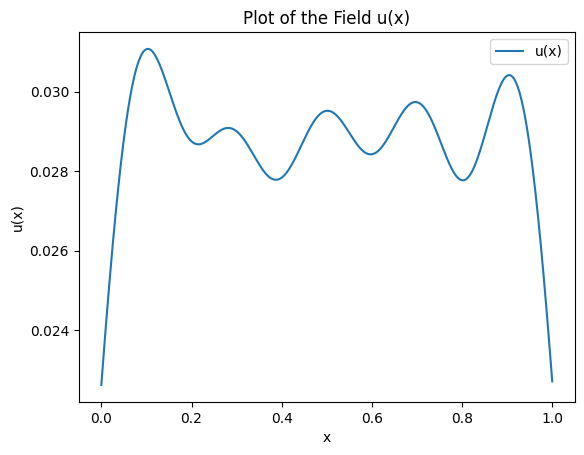

In [14]:
# Generate a set of weights w
u_values=[]

# Compute the field u(x)
for i in range(1000):
    print(i)
    w = np.random.normal(size=q)
    u_values.append(cal_u(w, x))

u_value=np.std(np.array(u_values),axis=0)
# Plot the field u(x)
plt.plot(x, u_value, label='u(x)')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('Plot of the Field u(x)')
plt.legend()
plt.show()

In [15]:
print(eigenvalues)

[ 1.23136278e-01  1.09418813e-01  8.99231761e-02  6.84123078e-02
  4.82457603e-02  3.15932800e-02  1.92507399e-02  1.09410102e-02
  5.81513805e-03  2.89826718e-03  1.35823984e-03  6.00095990e-04
  2.50585812e-04  9.91282416e-05  3.72293179e-05  1.33012900e-05
  4.52936183e-06  1.47256444e-06  4.57843218e-07  1.36342778e-07
  3.89447259e-08  1.06846091e-08  2.81917061e-09  7.16251621e-10
  1.75425211e-10  4.14643593e-11  9.46813556e-12  2.09068205e-12
  4.46839600e-13  9.25210297e-14  1.85745836e-14  3.61868320e-15
  6.84476506e-16  1.24608031e-16  2.47985456e-17  1.81047669e-17
  1.13722732e-17  1.06948969e-17  7.03023932e-18  5.76632934e-18
  5.34470812e-18  4.41829178e-18  3.60343622e-18  2.74461833e-18
  1.66118132e-18  1.06566155e-18  9.72480178e-19  9.23147939e-19
  8.49890847e-19  7.35348465e-19  6.69147110e-19  6.54206651e-19
  6.46009342e-19  6.33344317e-19  6.18566539e-19  5.74216392e-19
  5.73799725e-19  5.22878979e-19  4.19728774e-19  3.78294631e-19
  3.61119687e-19  3.30422

### FOR SPH

In [16]:
## defining constants
n_particles=J    ###  number of particles
dv = 1/n_particles   ### particle volume
rho0 = 1    ##### defining some random value of intial particle density
m_i = rho0*dv    ###### mass associated with each particle
c = 40/J    ###  radius/cutoff distance 
h = 1.5/J    ### smoothing length

#### creating neigbor list for particle
n_list = [ [] for i in range(n_particles) ]
x_dis = [ [] for i in range(n_particles) ]
for i in range(n_particles):
    for j in range(n_particles):
        if(i>j):
            k=-1
        else:
            k=1
        if(i!=j):
            if(np.linalg.norm(x[i]-x[j])<c):
                n_list[i].append(j)
                x_dis[i].append(x[i]-x[j])
            elif(a+dv-np.linalg.norm(x[i]-x[j])<c):
                n_list[i].append(j)
                x_dis[i].append(k*(a+dv-np.linalg.norm(x[i]-x[j])))
n_list=np.array(n_list)
x_dis=np.array(x_dis)

In [17]:
len(n_list[0])

78

In [18]:
### function to approximate the space derivative using SPH


# A=[]
# for i,neighbors in enumerate(n_list):
#     A.append(kernel(x_dis[i], h) * (x_dis[i]) * dv)
# A=np.array(A)
# B = 1/A

# print(B.shape)

def SPH(c,h,n_list=n_list):
    cd=np.zeros_like(c)
    for i,neighbors in enumerate(n_list):
        c_i = c[:, i][:, np.newaxis]  # Broadcasting to create the necessary shape
        c_i = np.repeat(c_i, len(neighbors), axis=1)
        c_j = c[:,neighbors]
        cd[:,i] = np.dot((c_i-c_j), -(1*kernel(x_dis[i], h))) * dv
    return cd

In [19]:
#### precomputing values of the scalar product
pre_values = np.zeros((q,q))
for i in range(q):
    for j in range(q):
        pre_values[i,j],_=quad_vec(lambda x: orthonormal_prob_hermite(i)(x) * orthonormal_prob_hermite(j)(x) * x * np.exp(-(x**2/2))/np.sqrt(2*np.pi), -20, 20)

In [20]:
# # Precompute the scalar product values values

# def integrand(u,i,j,w):
#     res=u
#     for idx in range(q):
#         res*=orthonormal_prob_hermite(i[idx])(w[idx])*orthonormal_prob_hermite(j[idx])(w[idx])
#     return res

# values=np.zeros(shape=(tot_P,tot_P,J))
# for i in range(tot_P):
#     print(i)
#     for j in range(i,tot_P):
#         for k in range(800):
#             w= np.random.normal(size=q)
#             # print(w.shape)
#             values[i,j,:]+=integrand(u(w,x),index[i],index[j],w)/800
#             values[j,i,:]+=integrand(u(w,x),index[i],index[j],w)/800
        

In [21]:

values=np.zeros(shape=(tot_P,tot_P,J))
for i in range(tot_P):
    print(i)
    for j in range(i,tot_P):
        flag=0
        idx=0
        for k in range(q):
            if(index[i][k]==index[j][k]):
                flag+=1
            else:
                idx=k
            # print(w.shape)
        # print(i,"  ",j, " ",flag)
        if(flag==q):
            values[i,j,:]=mean(x)
            values[j,i,:]=mean(x)
        elif(flag==(q-1)):
            # print(index[i],index[j],idx)
            values[i,j,:]=np.sqrt(eigenvalues[idx])*eigenvectors[:,idx]*pre_values[index[i][idx],index[j][idx]]
            values[j,i,:]=np.sqrt(eigenvalues[idx])*eigenvectors[:,idx]*pre_values[index[i][idx],index[j][idx]]
        else:
            values[i,j,:]=0
            values[j,i,:]=0
    print()

0

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

51

52

53

54

55



In [22]:
# from multiprocessing import Pool, cpu_count
# from functools import partial

# # Define the integrand function
# def integrand(u, i, j, w, q):
#     res = u
#     for idx in range(q):
#         res *= orthonormal_prob_hermite(i[idx])(w[idx]) * orthonormal_prob_hermite(j[idx])(w[idx])
#     return res

# # Define a function to compute values for a single pair (i, j)
# def compute_pair(u, index, q, J, i, j):
#     print(f"Computing for indices ({i}, {j})", flush=True)
#     values_ij = np.zeros(J)
#     for k in range(1000):
#         w = np.random.normal(size=q)
#         integrand_value = integrand(u(w, x), index[i], index[j], w, q) / 1000
#         values_ij += integrand_value
#     return i, j, values_ij

# # Main function to parallelize the computation
# def compute_values_parallel(u, index, q, tot_P, J):
#     values = np.zeros((tot_P, tot_P, J))
    
#     # Create a list of all (i, j) pairs
#     pairs = [(i, j) for i in range(tot_P) for j in range(i, tot_P)]
    
#     # Use multiprocessing Pool to parallelize the computation
#     with Pool(processes=cpu_count()) as pool:
#         results = pool.starmap(partial(compute_pair, u, index, q, J), pairs)
    
#     # Fill the values array with results
#     for i, j, values_ij in results:
#         values[i, j, :] = values_ij
#         values[j, i, :] = values_ij
    
#     return values

In [23]:
# values = compute_values_parallel(u, index, q, tot_P, J)

In [24]:
### Solving using predictor-corrector scheme
for n in range(1, N+1):
    c = ct[:, :, n-1]
    cd = SPH(c, h)
    rhs = np.zeros_like(cd)
    for i in range(tot_P):
        for j in range(tot_P):
            rhs[i, :] += cd[j, :] * values[i, j, :]

    # print(rhs.shape)
    # Predictor step
    ct_pred = ct[:, :, n-1] + 0.5 * rhs * dt

    # Corrector step
    cd_pred = SPH(ct_pred, h)
    rhs_pred = np.zeros_like(cd_pred)
    for i in range(tot_P):
        for j in range(tot_P):
            rhs_pred[i, :] += cd_pred[j, :] * values[i, j,:]

    ct[:, :, n] = ct[:, :, n-1] + 0.5 *0.5* (rhs + rhs_pred) * dt

    print(f"Completed the {n}^th timestep")

Completed the 1^th timestep
Completed the 2^th timestep
Completed the 3^th timestep
Completed the 4^th timestep
Completed the 5^th timestep
Completed the 6^th timestep
Completed the 7^th timestep
Completed the 8^th timestep
Completed the 9^th timestep
Completed the 10^th timestep
Completed the 11^th timestep
Completed the 12^th timestep
Completed the 13^th timestep
Completed the 14^th timestep
Completed the 15^th timestep
Completed the 16^th timestep
Completed the 17^th timestep
Completed the 18^th timestep
Completed the 19^th timestep
Completed the 20^th timestep
Completed the 21^th timestep
Completed the 22^th timestep
Completed the 23^th timestep
Completed the 24^th timestep
Completed the 25^th timestep
Completed the 26^th timestep
Completed the 27^th timestep
Completed the 28^th timestep
Completed the 29^th timestep
Completed the 30^th timestep
Completed the 31^th timestep
Completed the 32^th timestep
Completed the 33^th timestep
Completed the 34^th timestep
Completed the 35^th tim

In [25]:

u_mean=ct[0,:,:]

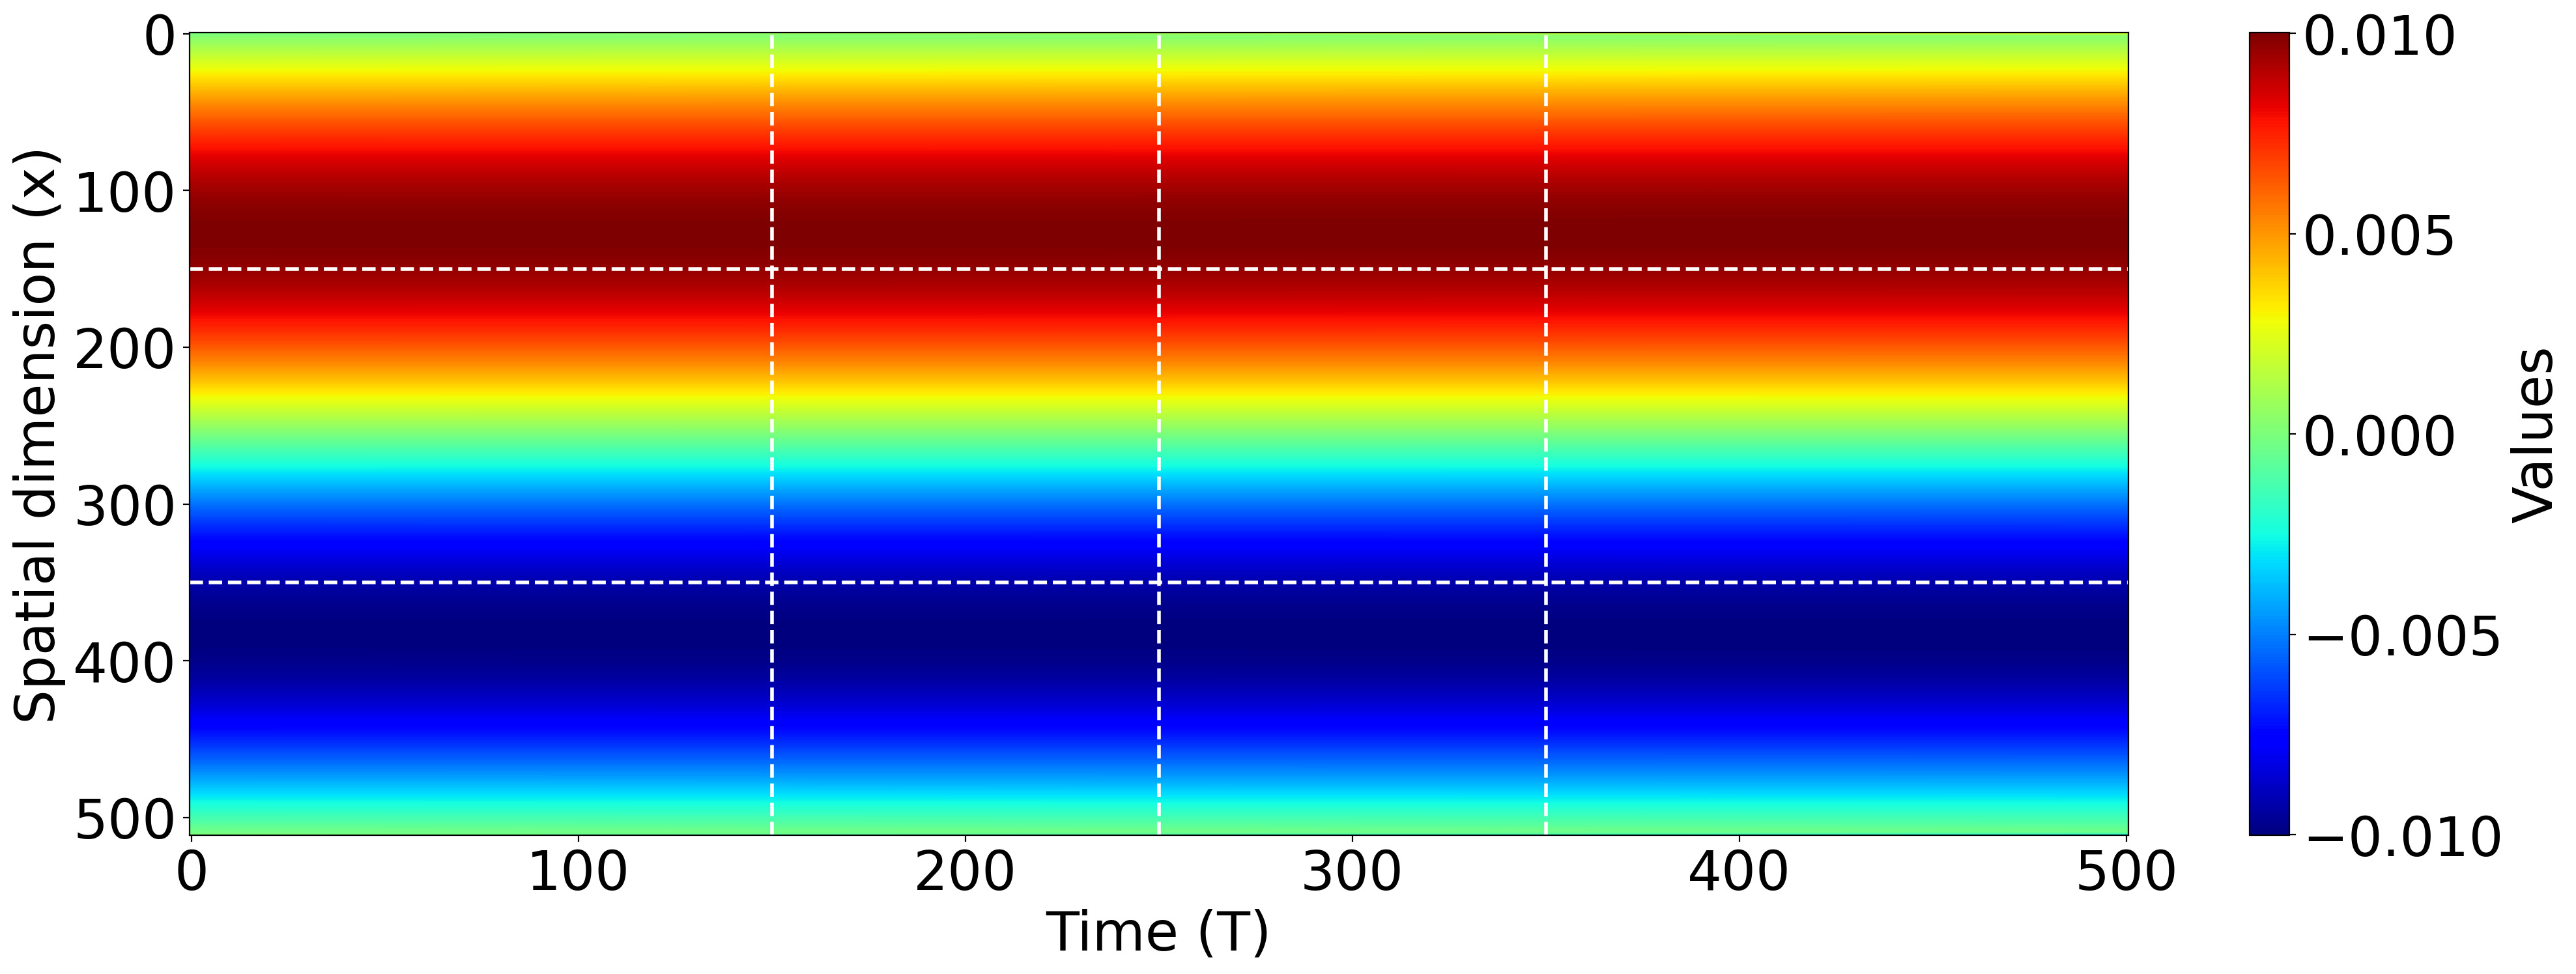

In [26]:
# set font sizes and math font
plt.rcParams['font.size'] = 30
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

# create figure
fig1 = plt.figure(figsize=(24, 8), dpi=200)

# plot heatmap
heatmap = plt.imshow(u_mean, aspect='auto', cmap='jet')

# add vertical lines at t = 150, 250, 350
for t in [150, 250, 350]:
    plt.axvline(x=t, color='white', linestyle='--', linewidth=2)

# add horizontal lines at x = 150, 350
for y in [150, 350]:
    plt.axhline(y=y, color='white', linestyle='--', linewidth=2)

# labels and colorbar
plt.xlabel('Time (T)')
plt.ylabel('Spatial dimension (x)')
cbar = plt.colorbar(heatmap)
cbar.set_label('Values')

plt.show()

In [27]:
def calculate_sq(ct,tot_P,u_mean):
    f=0
    for idx in range(1,tot_P):
        f+= (ct[idx,:,:]**2)
    return  f

u_std=np.sqrt(calculate_sq(ct,tot_P,u_mean))

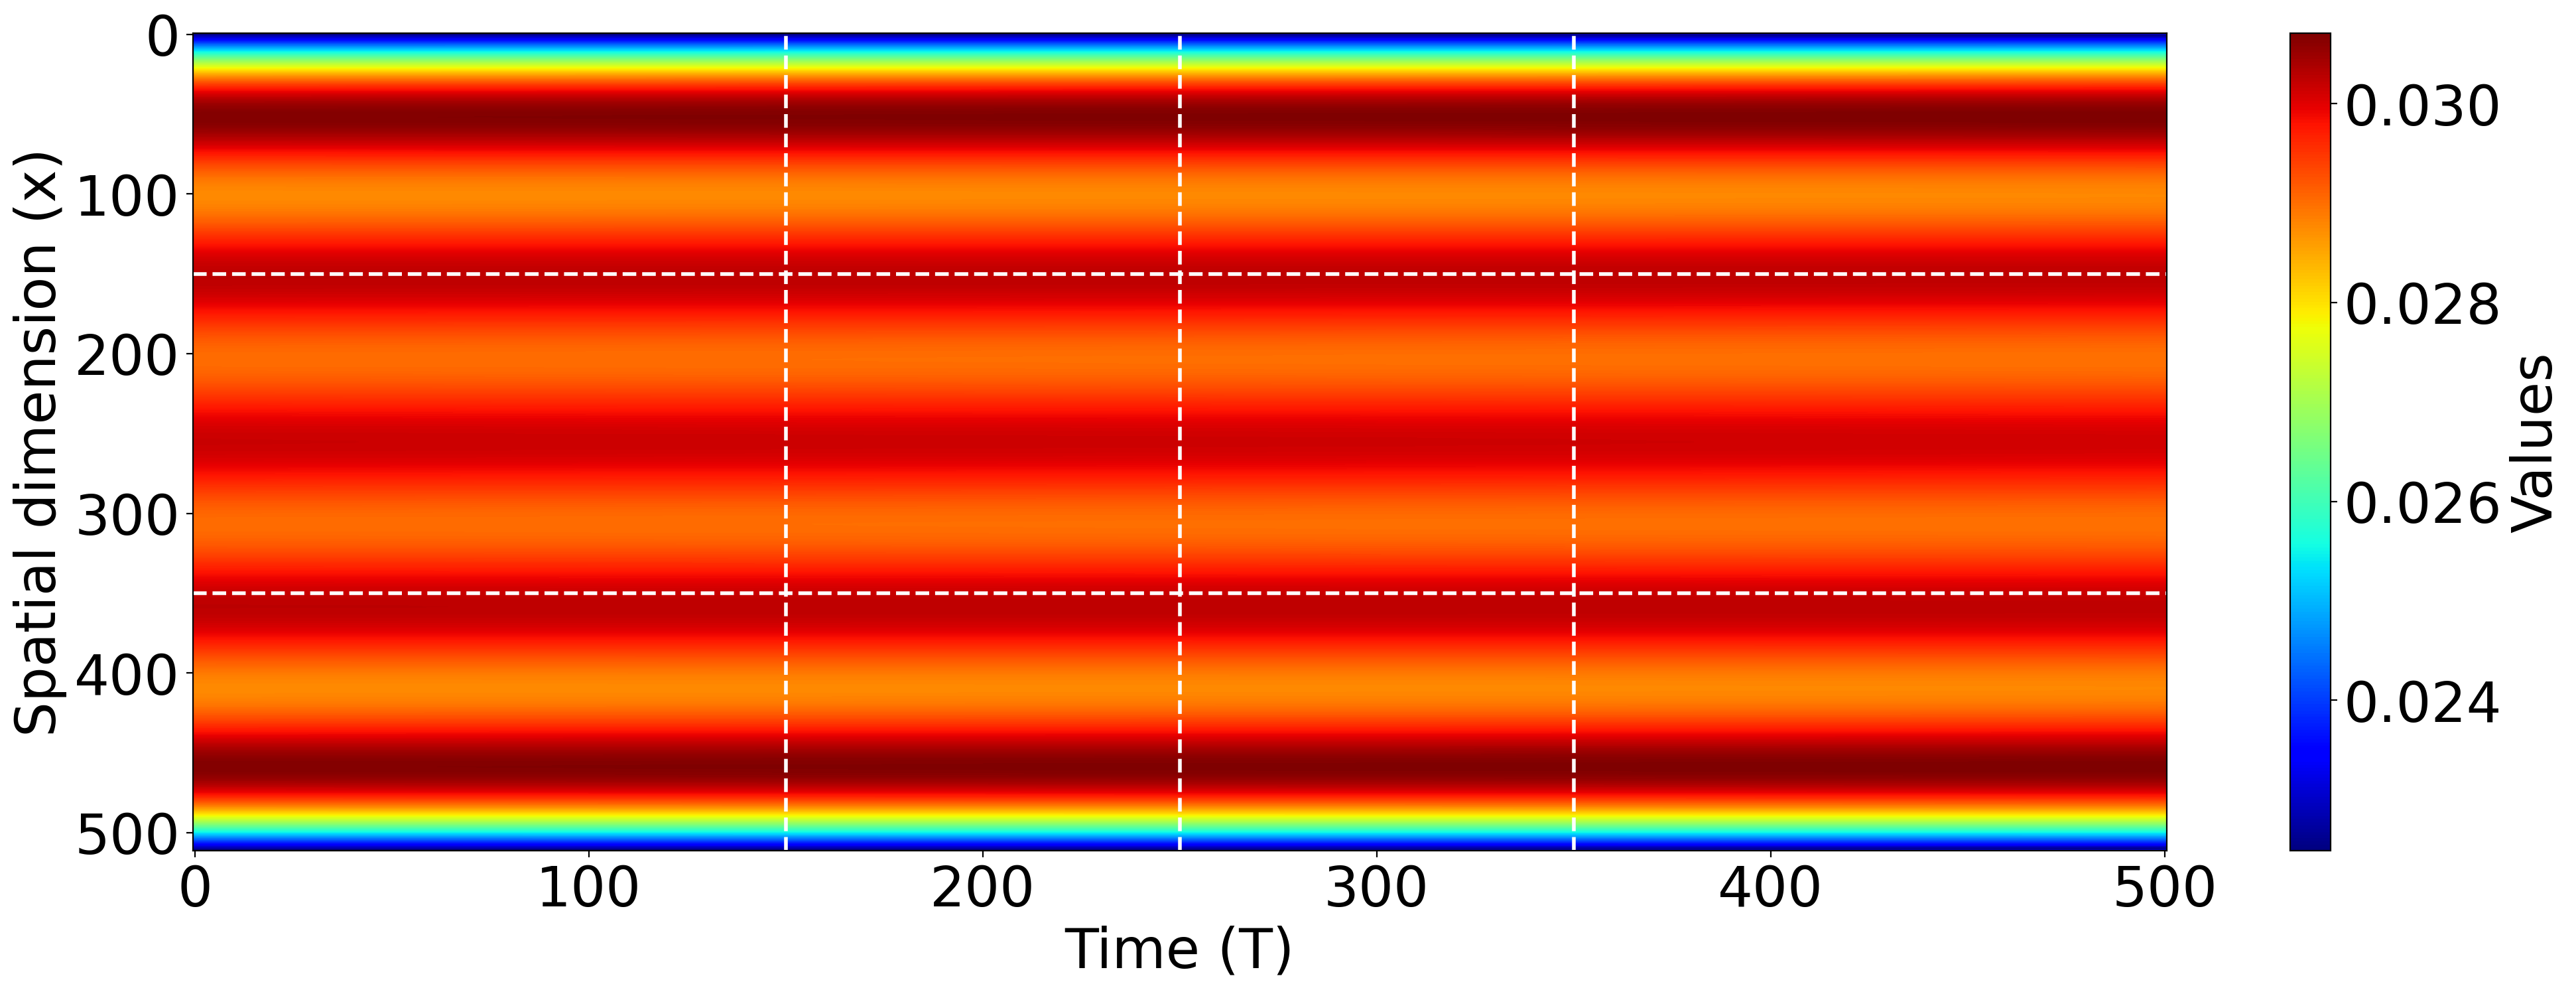

In [28]:
# set font sizes and math font
plt.rcParams['font.size'] = 30
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

# create figure
fig1 = plt.figure(figsize=(24, 8), dpi=200)

# plot heatmap
heatmap = plt.imshow(u_std, aspect='auto', cmap='jet')

# add vertical lines at t = 150, 250, 350
for t in [150, 250, 350]:
    plt.axvline(x=t, color='white', linestyle='--', linewidth=2)

# add horizontal lines at x = 150, 350
for y in [150, 350]:
    plt.axhline(y=y, color='white', linestyle='--', linewidth=2)

# labels and colorbar
plt.xlabel('Time (T)')
plt.ylabel('Spatial dimension (x)')
cbar = plt.colorbar(heatmap)
cbar.set_label('Values')

plt.show()

In [29]:
# WE'LL FIRST DEFINE A FUNCTION THAT CALCULATES THE SPATIAL DERIVATIVE USING CENTRAL DIFFERENCE
def SPH_mcs(c,h,n_list=n_list):
    cd=np.zeros_like(c)
    for i,neighbors in enumerate(n_list):
        c_i = c[i][np.newaxis]  # Broadcasting to create the necessary shape
        c_i = np.repeat(c_i, len(neighbors), axis=0)
        c_j=c[neighbors]
        cd[i] = np.dot((c_i-c_j), -(kernel(x_dis[i], h))) * dv
    return cd

In [30]:
def CD_upwind(u, dx, alpha):
    """
    First-order upwind derivative for u_x given advection speed alpha.
    Periodic BC’s handled by np.roll.
    """
    if alpha >= 0:
        # backward difference
        return (u - np.roll(u, 1)) / dx
    else:
        # forward difference
        return (np.roll(u, -1) - u) / dx

def solver(u0, a, J, N, T, alpha):
    """
    Solve u_t = -alpha * u_x  on x∈[0,a) with periodic BC’s,
    using explicit Euler in time and upwind in space.
    Returns ut[:, n] = u at t = n*dt, for n=0..N.
    """
    dx = a / J
    dt = T / N
    # time‐levels t=0,dt,...,T
    t = np.linspace(0, T, N+1)
    
    # storage
    ut = np.zeros((J, N+1))
    print(ut.shape)
    u  = u0.copy()
    ut[:, 0] = u0

    for n in range(N):
        u_x = CD_upwind(u, dx, alpha)
        # note the minus sign for u_t + alpha u_x = 0
        u = u - dt * alpha * u_x
        u[J-1]=u[0]
        ut[:, n+1] = u

    return ut, t

In [31]:

x = np.arange(0,a,a/J)           # Discretization points

print("STARTING MCS")
ut_mcs=[]
i=0
alphas = np.ones(2500)*0.5
for alpha in alphas:
    i+=1
    print(i)
    ws=np.random.normal(size=(q,))
    u0 = cal_u(ws)                # Initial condition
    
    ut, t = solver(u0, a, J, N,T,alpha=alpha)
    ut_mcs.append(ut)
ut_mcs=np.array(ut_mcs)

ut_mean1 = np.mean(ut_mcs,axis=0)
ut_std1 = np.std(ut_mcs,axis=0)

del ut_mcs
ut_mcs=[]
i=0
for alpha in alphas:
    i+=1
    print(i)
    ws=np.random.normal(size=(q,))
    u0 = cal_u(ws)                # Initial condition
    ut, t = solver(u0, a, J, N,T,alpha=alpha)
    ut_mcs.append(ut)
ut_mcs=np.array(ut_mcs)

ut_mean2 = np.mean(ut_mcs,axis=0)
ut_std2 = np.std(ut_mcs,axis=0)
del ut_mcs
print("FINISHING MCS")

STARTING MCS
1
(512, 501)
2
(512, 501)
3
(512, 501)
4
(512, 501)
5
(512, 501)
6
(512, 501)
7
(512, 501)
8
(512, 501)
9
(512, 501)
10
(512, 501)
11
(512, 501)
12
(512, 501)
13
(512, 501)
14
(512, 501)
15
(512, 501)
16
(512, 501)
17
(512, 501)
18
(512, 501)
19
(512, 501)
20
(512, 501)
21
(512, 501)
22
(512, 501)
23
(512, 501)
24
(512, 501)
25
(512, 501)
26
(512, 501)
27
(512, 501)
28
(512, 501)
29
(512, 501)
30
(512, 501)
31
(512, 501)
32
(512, 501)
33
(512, 501)
34
(512, 501)
35
(512, 501)
36
(512, 501)
37
(512, 501)
38
(512, 501)
39
(512, 501)
40
(512, 501)
41
(512, 501)
42
(512, 501)
43
(512, 501)
44
(512, 501)
45
(512, 501)
46
(512, 501)
47
(512, 501)
48
(512, 501)
49
(512, 501)
50
(512, 501)
51
(512, 501)
52
(512, 501)
53
(512, 501)
54
(512, 501)
55
(512, 501)
56
(512, 501)
57
(512, 501)
58
(512, 501)
59
(512, 501)
60
(512, 501)
61
(512, 501)
62
(512, 501)
63
(512, 501)
64
(512, 501)
65
(512, 501)
66
(512, 501)
67
(512, 501)
68
(512, 501)
69
(512, 501)
70
(512, 501)
71
(512, 501)
72

In [32]:
mean_mcs =(ut_mean1+ut_mean2)/2 
std_mcs = np.sqrt((ut_std1**2+ut_std2**2)/2)

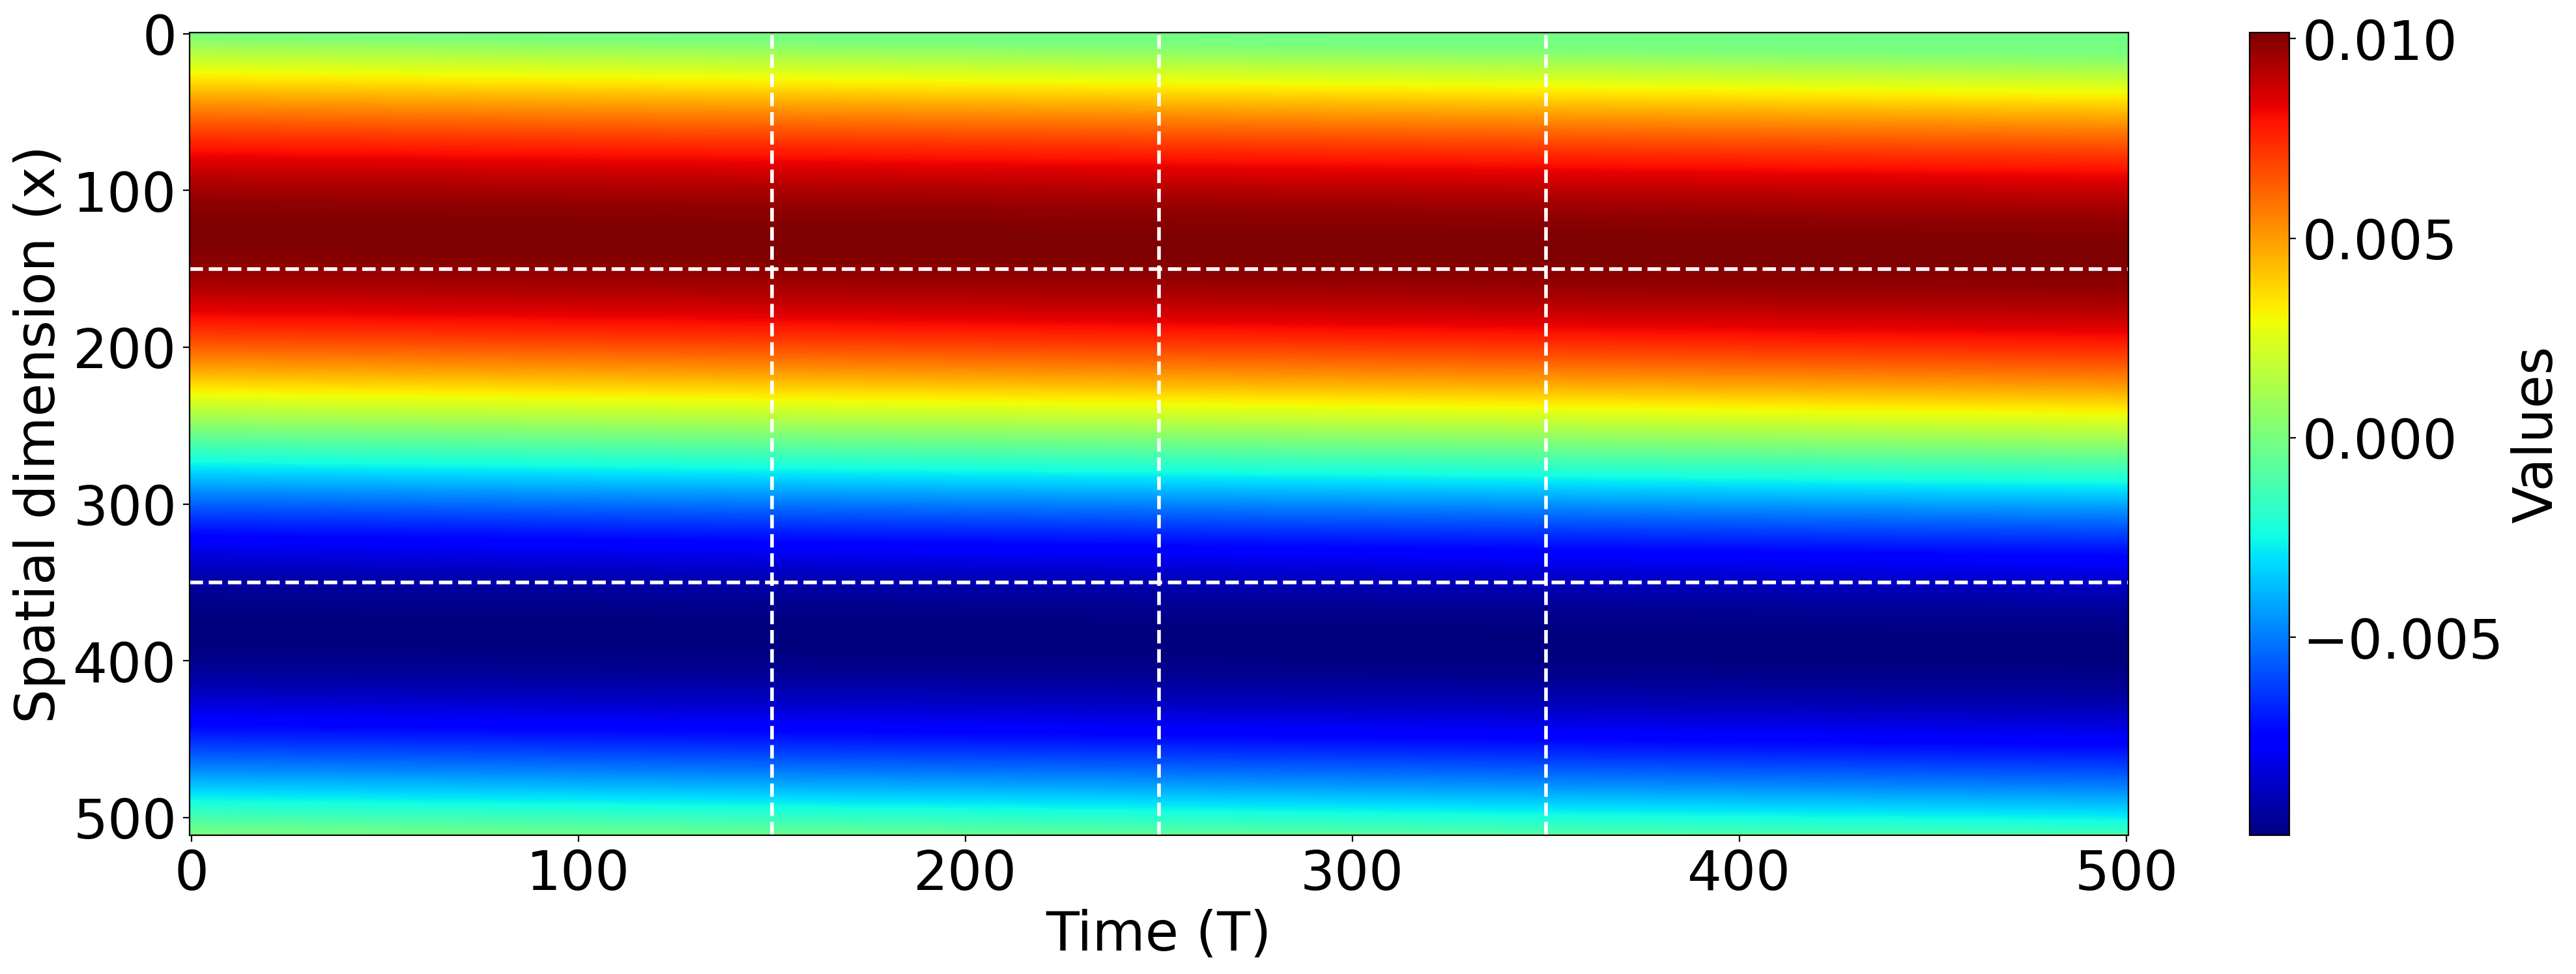

In [33]:
# set font sizes and math font
plt.rcParams['font.size'] = 30
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

# create figure
fig1 = plt.figure(figsize=(24, 8), dpi=200)

# plot heatmap
heatmap = plt.imshow(mean_mcs, aspect='auto', cmap='jet')

# add vertical lines at t = 150, 250, 350
for t in [150, 250, 350]:
    plt.axvline(x=t, color='white', linestyle='--', linewidth=2)

# add horizontal lines at x = 150, 350
for y in [150, 350]:
    plt.axhline(y=y, color='white', linestyle='--', linewidth=2)

# labels and colorbar
plt.xlabel('Time (T)')
plt.ylabel('Spatial dimension (x)')
cbar = plt.colorbar(heatmap)
cbar.set_label('Values')

plt.show()

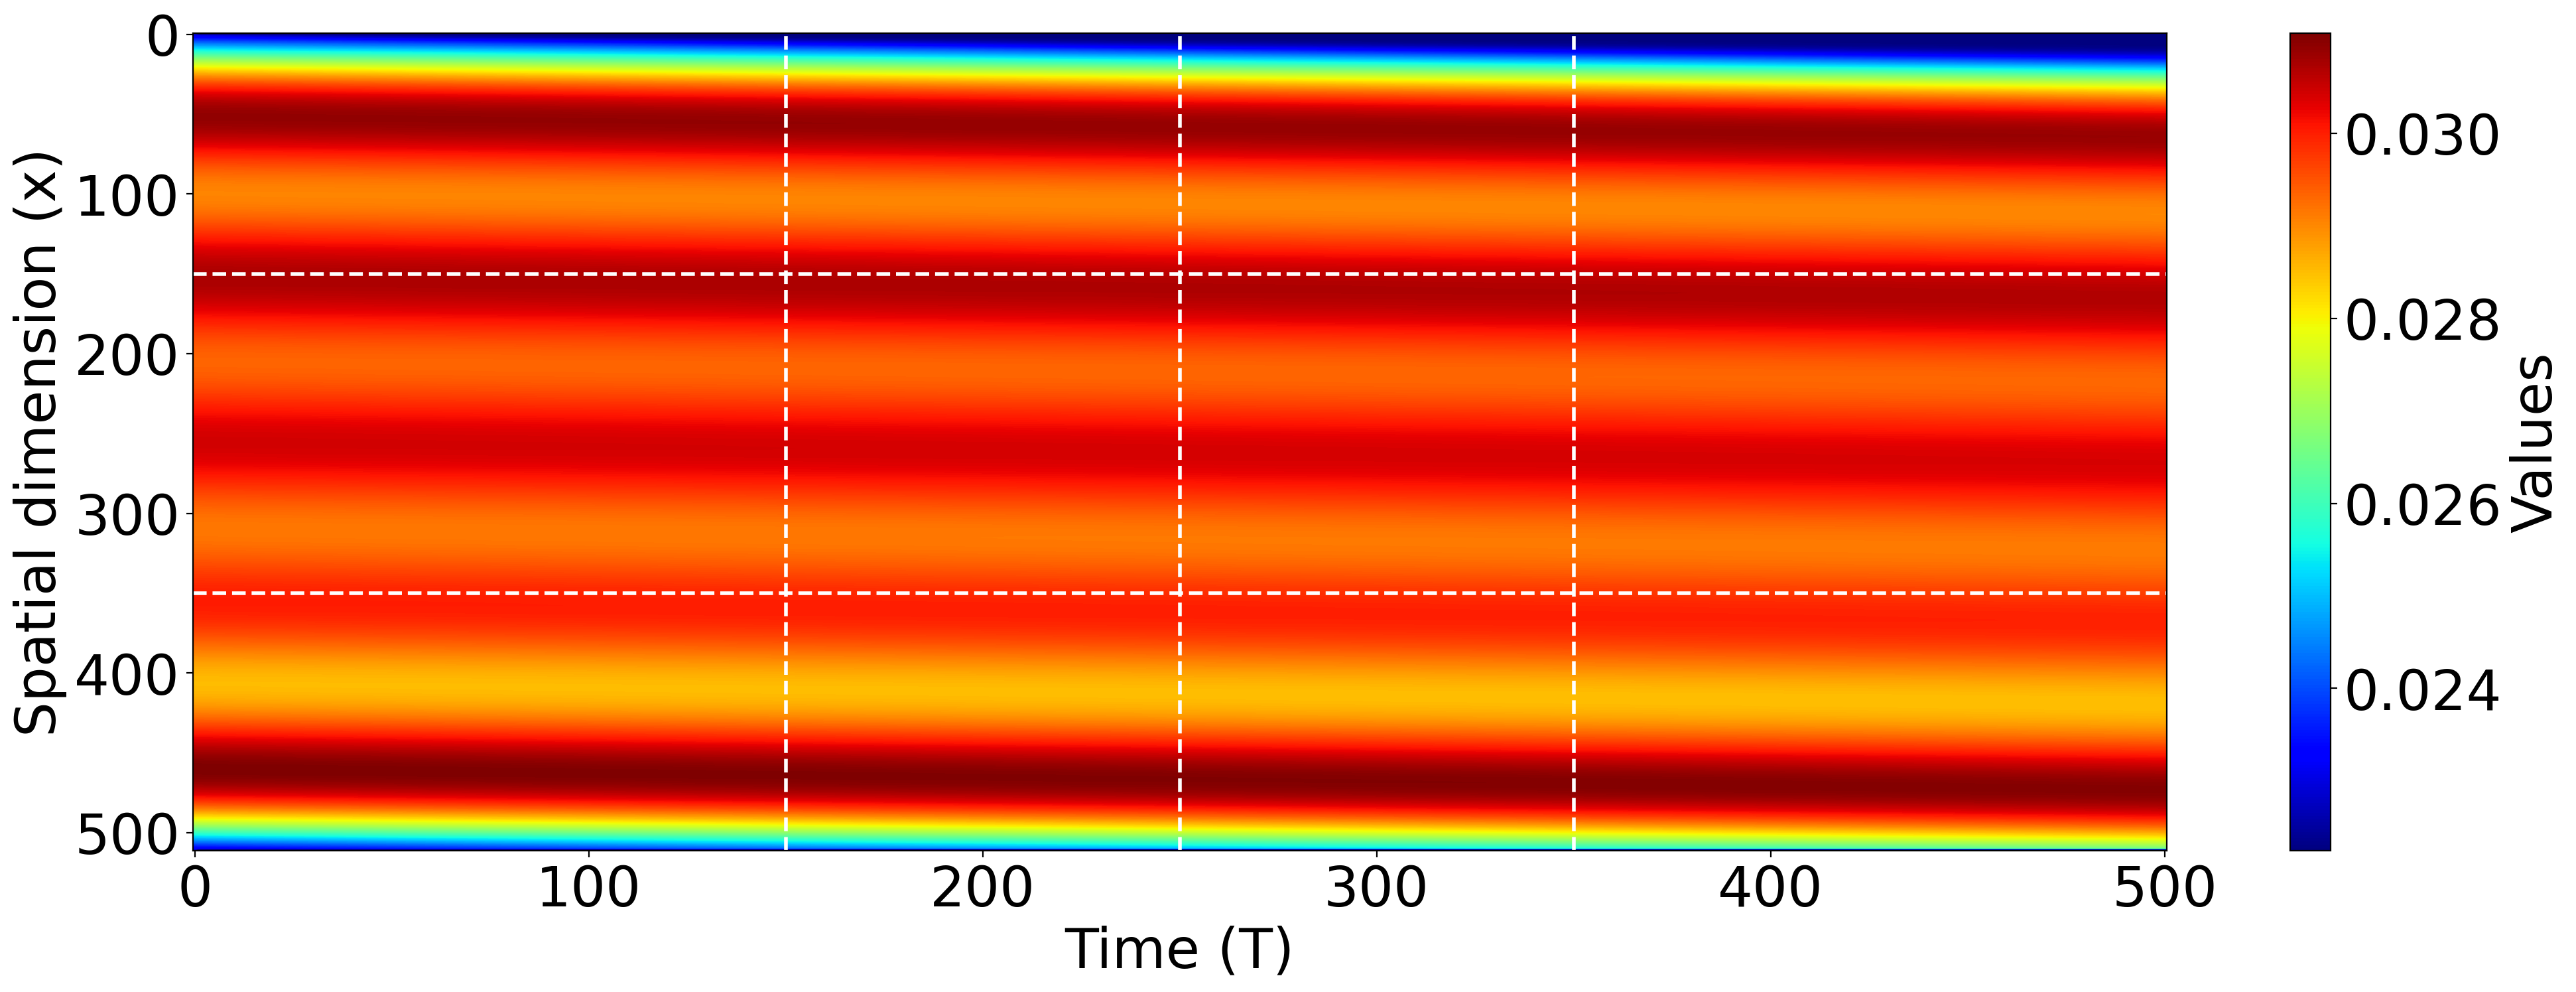

In [34]:
# set font sizes and math font
plt.rcParams['font.size'] = 30
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

# create figure
fig1 = plt.figure(figsize=(24, 8), dpi=200)

# plot heatmap
heatmap = plt.imshow(std_mcs, aspect='auto', cmap='jet')

# add vertical lines at t = 150, 250, 350
for t in [150, 250, 350]:
    plt.axvline(x=t, color='white', linestyle='--', linewidth=2)

# add horizontal lines at x = 150, 350
for y in [150, 350]:
    plt.axhline(y=y, color='white', linestyle='--', linewidth=2)

# labels and colorbar
plt.xlabel('Time (T)')
plt.ylabel('Spatial dimension (x)')
cbar = plt.colorbar(heatmap)
cbar.set_label('Values')

plt.show()

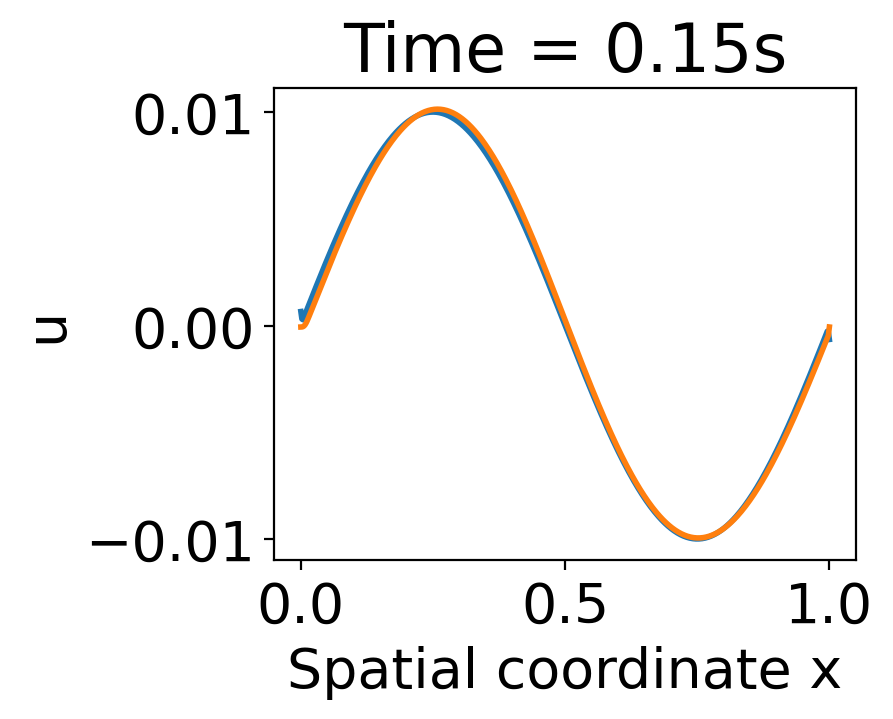

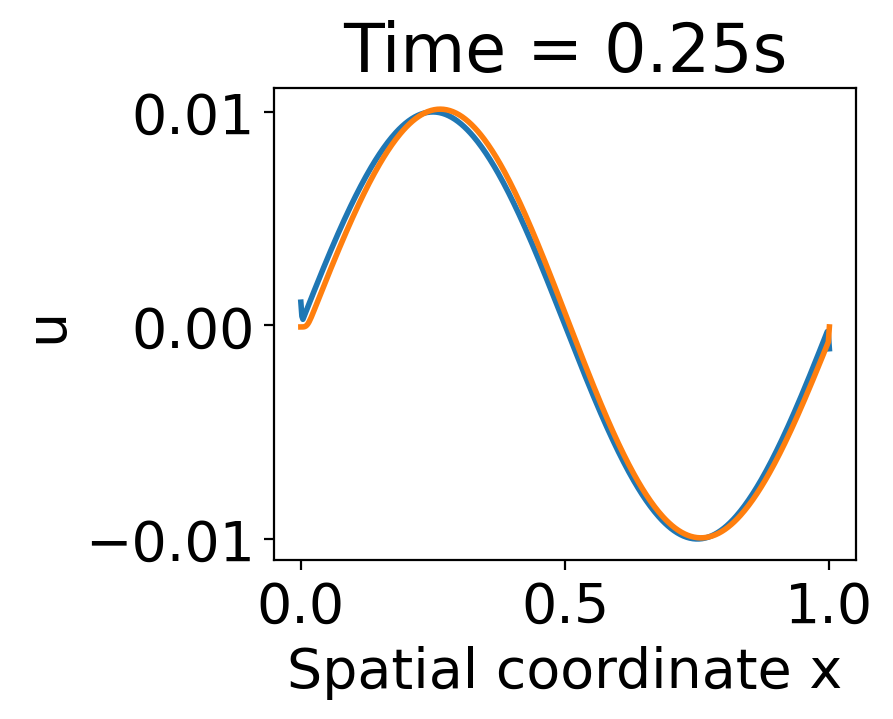

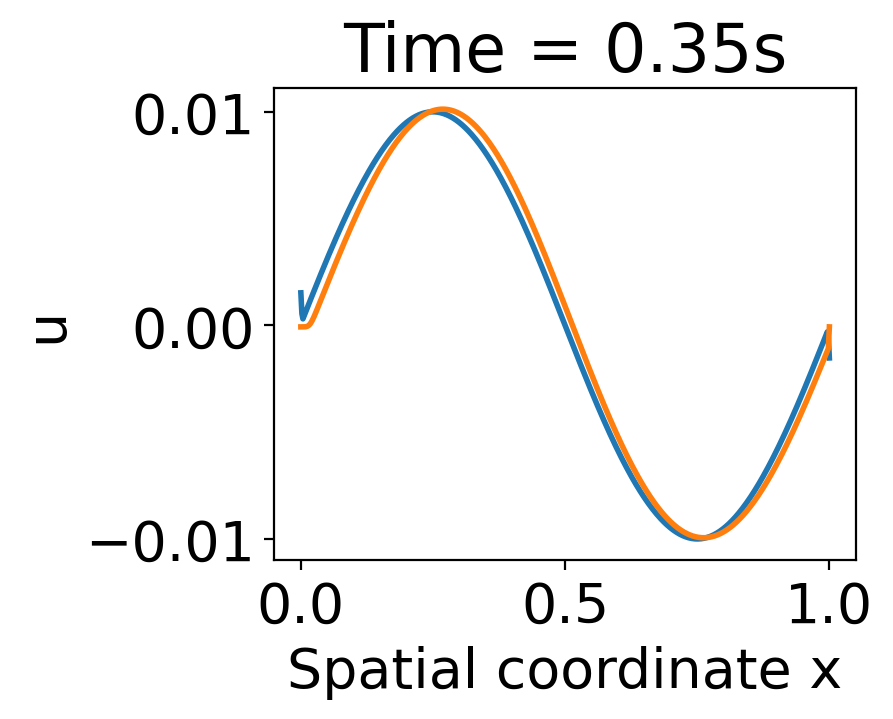

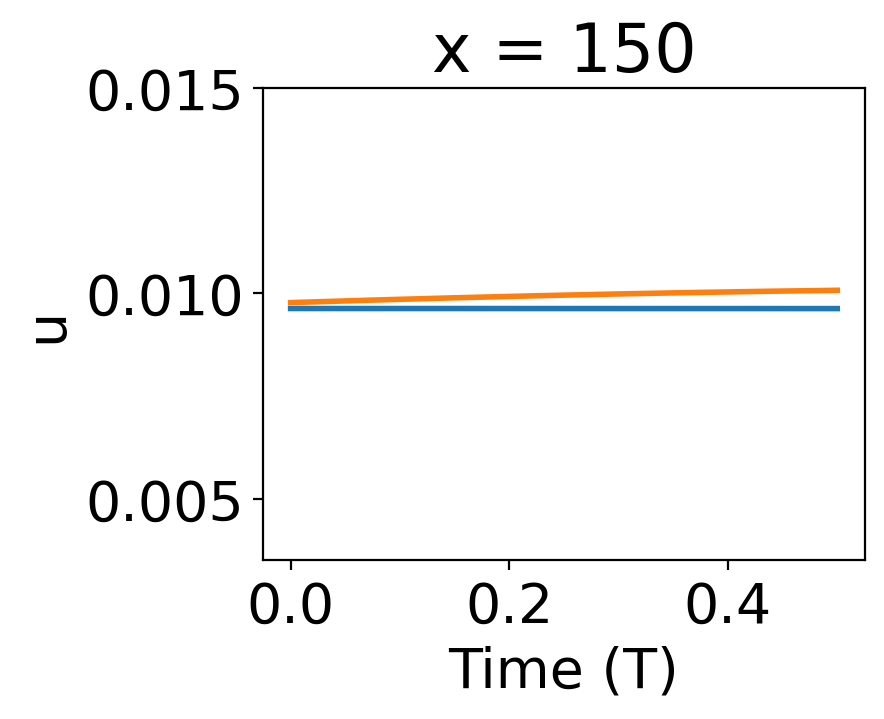

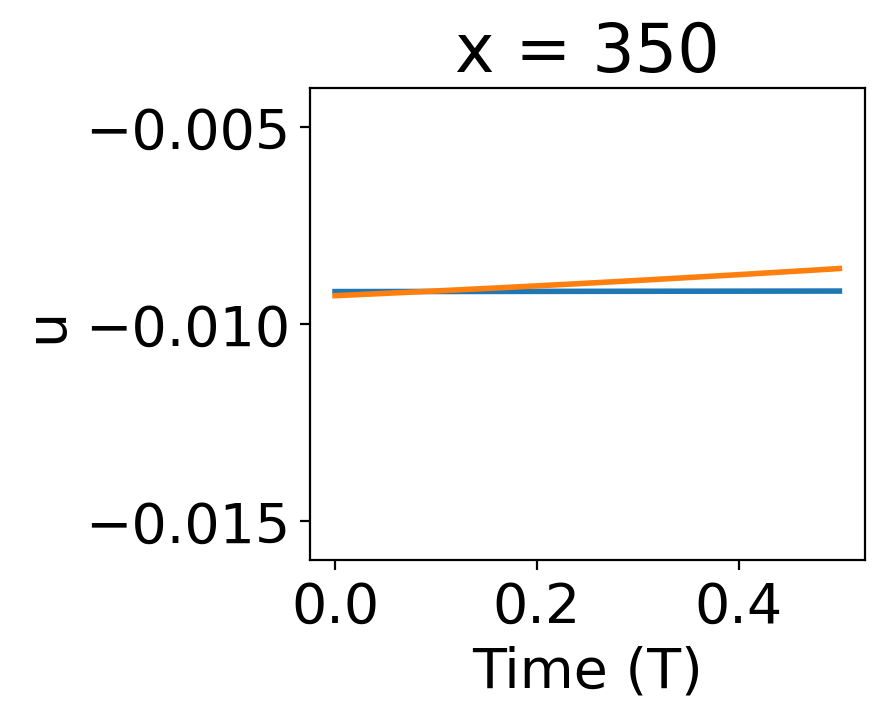

In [53]:

plt.rcParams['font.size'] = 20
# ------------------------------------------------------
# 1) Prepare your data & coordinates
# ------------------------------------------------------
# u_mean: 2D array of shape (nx, nt)
# x:    1D array (length nx) giving the spatial grid coordinates
# t:    1D array (length nt) giving the time grid coordinates

# Example placeholders (replace with your real arrays):
x = np.linspace(0, 1, u_mean.shape[0])
t = np.linspace(0, 0.5, u_mean.shape[1])

# ------------------------------------------------------
# 2) Choose five slices in time and five in space
# ------------------------------------------------------
fixed_times = [150, 250, 350]   # time-coordinates you want to hold fixed
fixed_xs    = [150, 350]   # spatial-coordinates you want to hold fixed

# find the nearest indices in your grid
time_inds = [np.abs(ti) for ti in fixed_times]
x_inds    = [np.abs(xi) for xi in fixed_xs]

# ------------------------------------------------------
# 3) Plot u(x) at each fixed time
# ------------------------------------------------------
for ti, tval in zip(time_inds, fixed_times):
    plt.figure(figsize=(5, 4), dpi=200)
    plt.plot(x, u_mean[:, ti], linewidth=2)
    plt.plot(x, mean_mcs[:, ti], linewidth=2)
    plt.title(f'Time = {tval/1000}s')
    plt.xlabel('Spatial coordinate x')
    plt.ylabel('u')
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------
# 4) Plot u(t) at each fixed spatial location
# ------------------------------------------------------
i=0
for xi, xval in zip(x_inds, fixed_xs):
    plt.figure(figsize=(5, 4), dpi=200)
    plt.plot(t, u_mean[xi, :], linewidth=2)
    plt.plot(t, mean_mcs[xi, :], linewidth=2)
    plt.title(f'x = {xval}')
    plt.xlabel('Time (T)')
    plt.ylabel('u')
    if(i==0):
        plt.ylim(0.0035,0.015)
    else:
        plt.ylim(-0.016,-0.004)
        
    i+=1
    plt.tight_layout()
    plt.show()

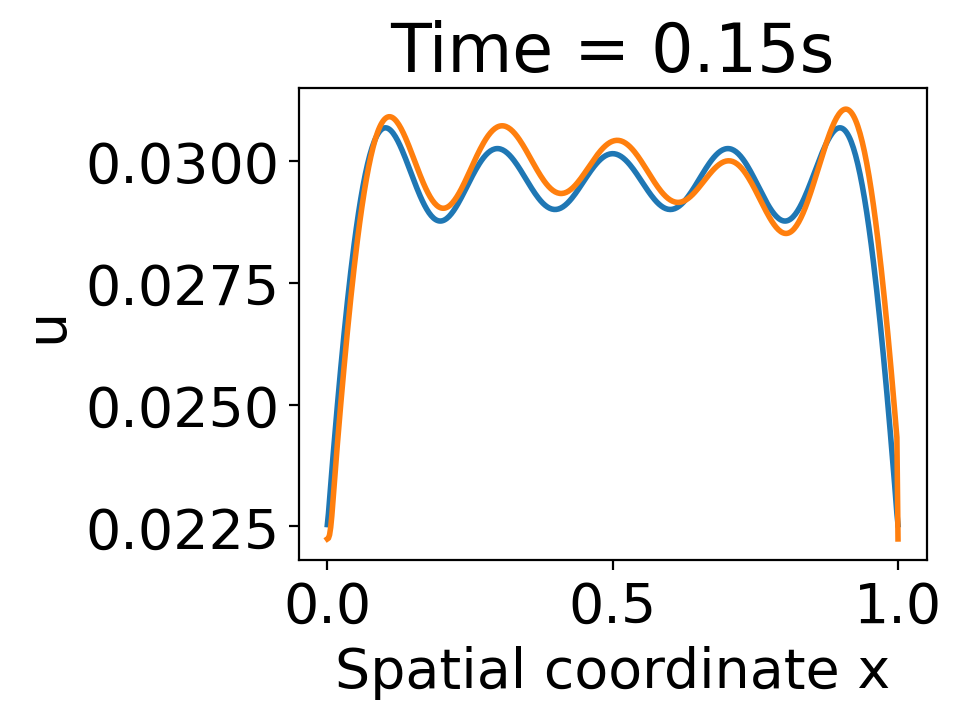

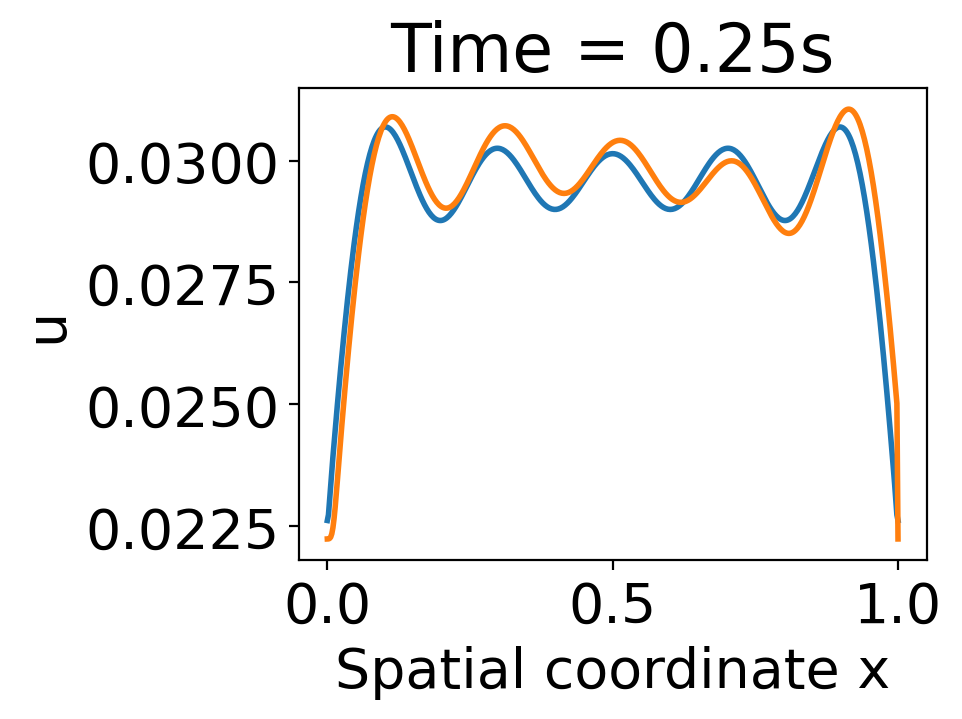

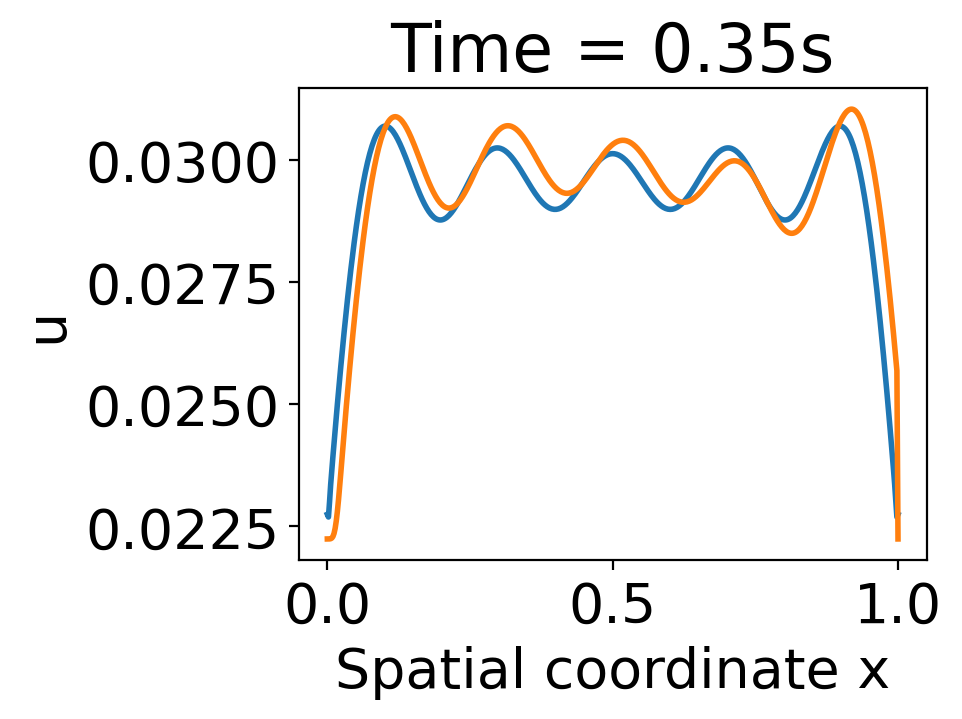

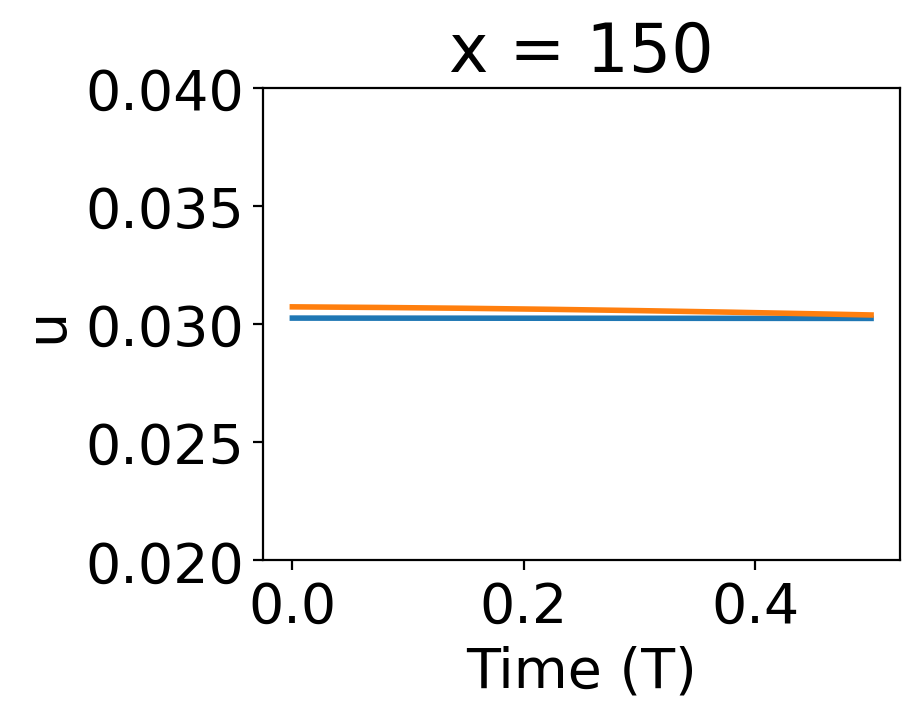

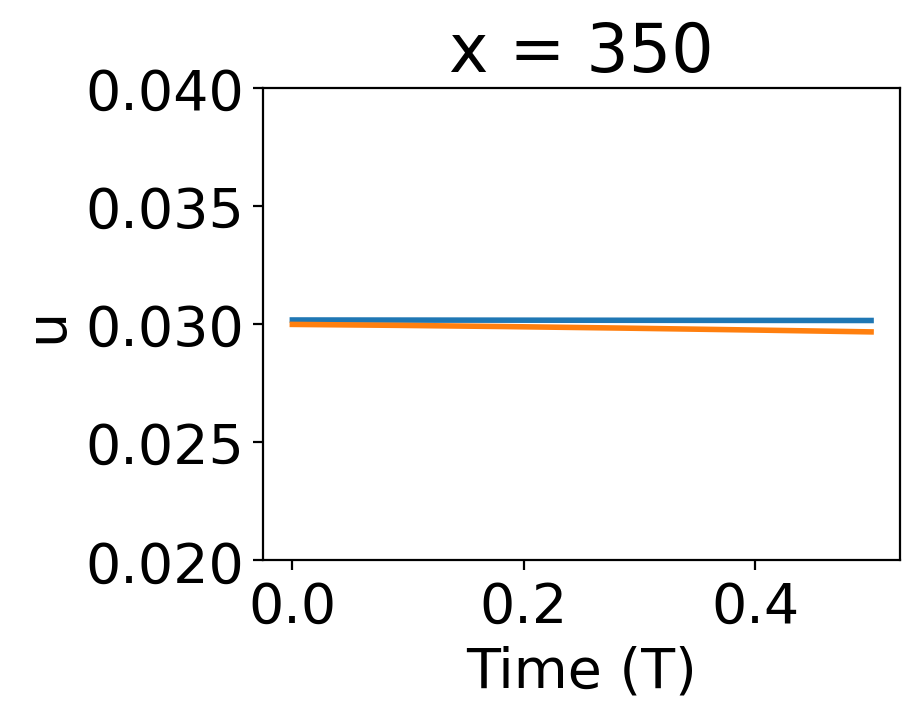

In [51]:
plt.rcParams['font.size'] = 20
# ------------------------------------------------------
# 1) Prepare your data & coordinates
# ------------------------------------------------------
# u_mean: 2D array of shape (nx, nt)
# x:    1D array (length nx) giving the spatial grid coordinates
# t:    1D array (length nt) giving the time grid coordinates

# Example placeholders (replace with your real arrays):
x = np.linspace(0, 1, u_mean.shape[0])
t = np.linspace(0, 0.5, u_mean.shape[1])

# ------------------------------------------------------
# 2) Choose five slices in time and five in space
# ------------------------------------------------------
fixed_times = [150, 250, 350]   # time-coordinates you want to hold fixed
fixed_xs    = [150, 350]   # spatial-coordinates you want to hold fixed

# find the nearest indices in your grid
time_inds = [np.abs(ti) for ti in fixed_times]
x_inds    = [np.abs(xi) for xi in fixed_xs]

# ------------------------------------------------------
# 3) Plot u(x) at each fixed time
# ------------------------------------------------------
for ti, tval in zip(time_inds, fixed_times):
    plt.figure(figsize=(5, 4), dpi=200)
    plt.plot(x, u_std[:, ti], linewidth=2)
    plt.plot(x, std_mcs[:, ti], linewidth=2)
    plt.title(f'Time = {tval/1000}s')
    plt.xlabel('Spatial coordinate x')
    plt.ylabel('u')
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------
# 4) Plot u(t) at each fixed spatial location
# ------------------------------------------------------
i=0
for xi, xval in zip(x_inds, fixed_xs):
    plt.figure(figsize=(5, 4), dpi=200)
    plt.plot(t, u_std[xi, :], linewidth=2)
    plt.plot(t, std_mcs[xi, :], linewidth=2)
    plt.title(f'x = {xval}')
    plt.xlabel('Time (T)')
    plt.ylabel('u')
    if(i==0):
        plt.ylim(0.02,0.04)
    else:
        plt.ylim(0.02,0.04)
        
    i+=1
    plt.tight_layout()
    plt.show()